In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### Question Three

2.3. Consider the challenge of classifying the likelihood of survival using the Titanic dataset. Construct a decision tree and display the structure of this tree using a graphic. 


In [21]:
titanic_data = pd.read_csv('titanic3.csv')[["age", "sex", "pclass", "survived"]]
titanic_data.head()

,age,sex,pclass,survived
0,29.00,female,1,1
1,0.92,male,1,1
2,2.00,female,1,0
3,30.00,male,1,0
4,25.00,female,1,0


Prepare the data

In [22]:
# heck for NaN values
titanic_data.isna().sum()

age         263
sex           0
pclass        0
survived      0
dtype: int64

In [23]:
# Calculate the mean age
mean_age = titanic_data["age"].mean()

# Replace all the NaN values with the mean age
titanic_data["age"] = titanic_data["age"].fillna(mean_age)

#Check for NaN values
titanic_data.isna().sum()

age         0
sex         0
pclass      0
survived    0
dtype: int64

In [24]:
# Convert the gender column to float values
titanic_data["sex binary"] = titanic_data.sex.map({"female":0, "male":1})

# Validate the transformed sex column
titanic_data.head()

,age,sex,pclass,survived,sex binary
0,29.00,female,1,1,0
1,0.92,male,1,1,1
2,2.00,female,1,0,0
3,30.00,male,1,0,1
4,25.00,female,1,0,0


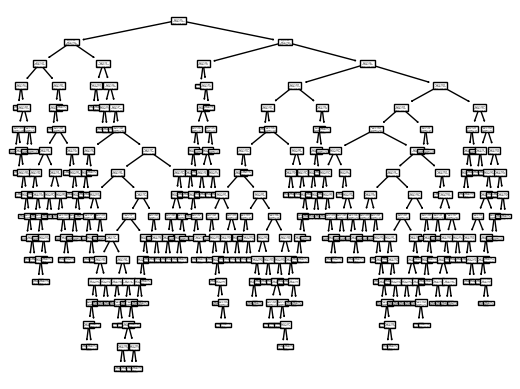

In [38]:
# Set the X and y values
titanic_X = titanic_data.drop(columns = ["survived", "sex"])
titanic_y = titanic_data[["survived"]]

# Create the model
clf = DecisionTreeClassifier(random_state = 0)

# Fit the titanic data onto the model
titanic_model = clf.fit(titanic_X, titanic_y)

# Plot the tree from the model created
tree.plot_tree(titanic_model)
plt.show()